In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Wed Jan 24 12:17:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.batch_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0

hp.M = hp.n_prior_embeddings
hp.N = (hp.img_size//4)**2 * hp.batch_size

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma

p_samples1 = (torch.rand(hp.M, hp.z_dim)*2-1).cuda()
p_samples2 = (torch.rand(hp.N, hp.z_dim)*2-1).cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

-0.5151515151515151


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_noupdate/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 8515, model_list, optimizer_list)

total 16108
-rw-rw-r-- 1 scpark scpark       0  1월 24 12:18 events.out.tfevents.1706066297.GPUSVR11
-rw-rw-r-- 1 scpark scpark 1242840  1월 24 12:17 events.out.tfevents.1706065404.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7477253  1월 24 12:17 save_8515
-rw-rw-r-- 1 scpark scpark 7470716  1월 24 12:03 save_0
-rw-rw-r-- 1 scpark scpark  254566  1월 24 11:59 events.out.tfevents.1706065002.GPUSVR11
-rw-rw-r-- 1 scpark scpark      40  1월 24 11:56 events.out.tfevents.1706064899.GPUSVR11
-rw-rw-r-- 1 scpark scpark   36004  1월 24 11:56 events.out.tfevents.1706064902.GPUSVR11


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

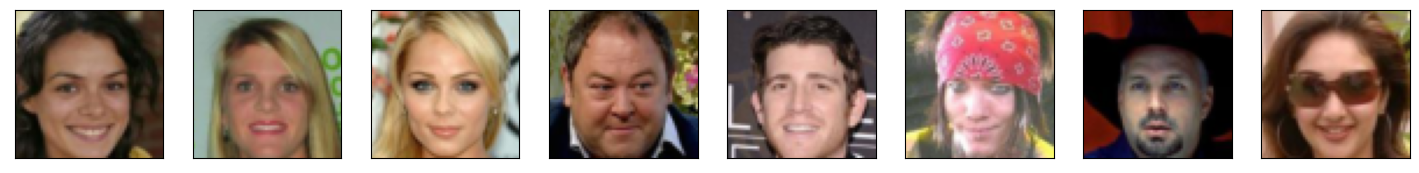

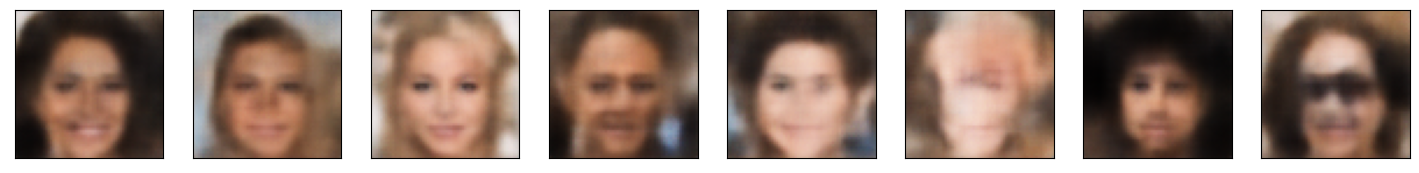

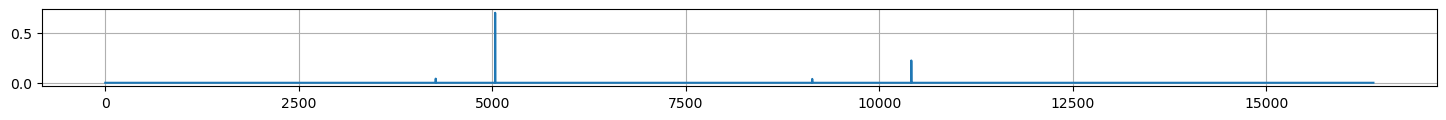

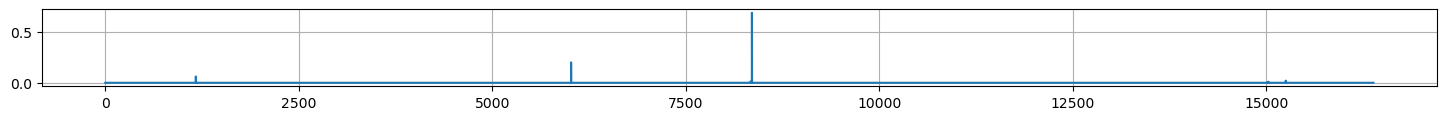

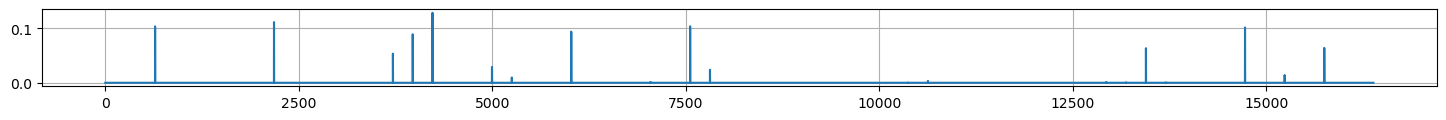

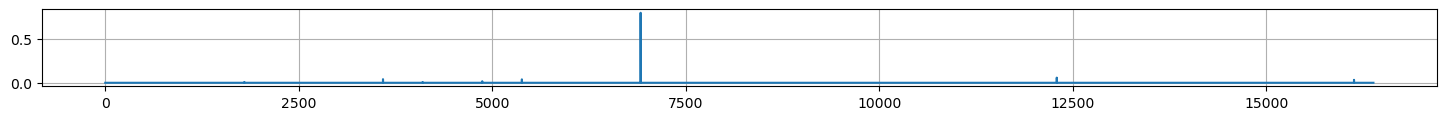

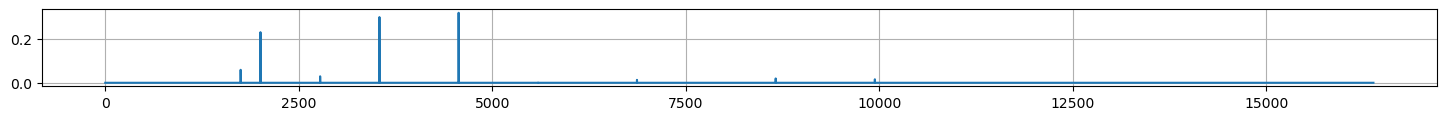

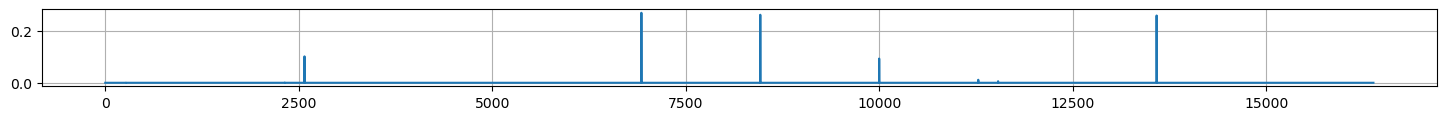

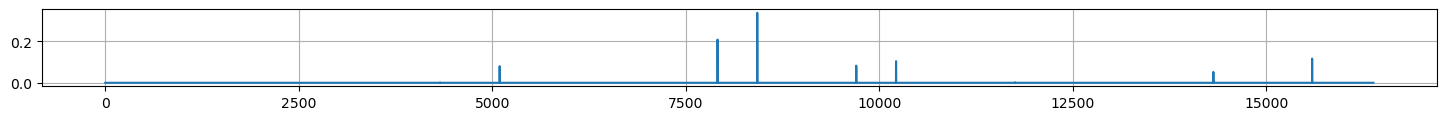

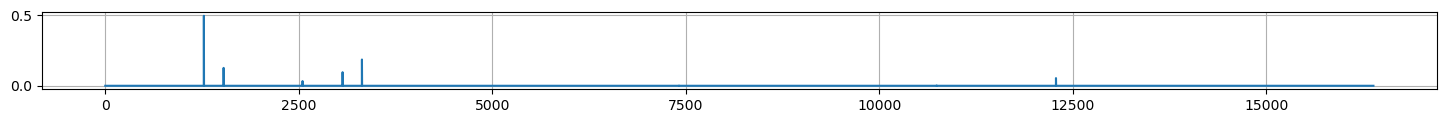

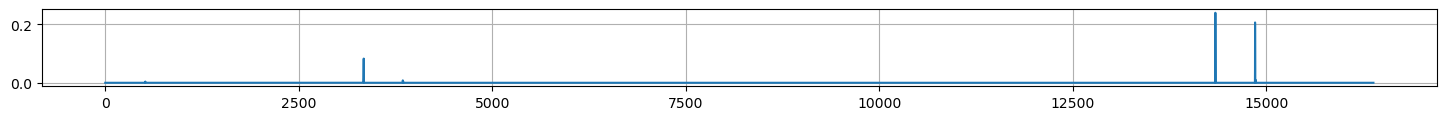

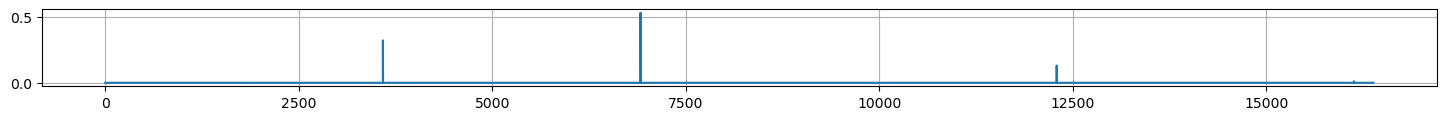

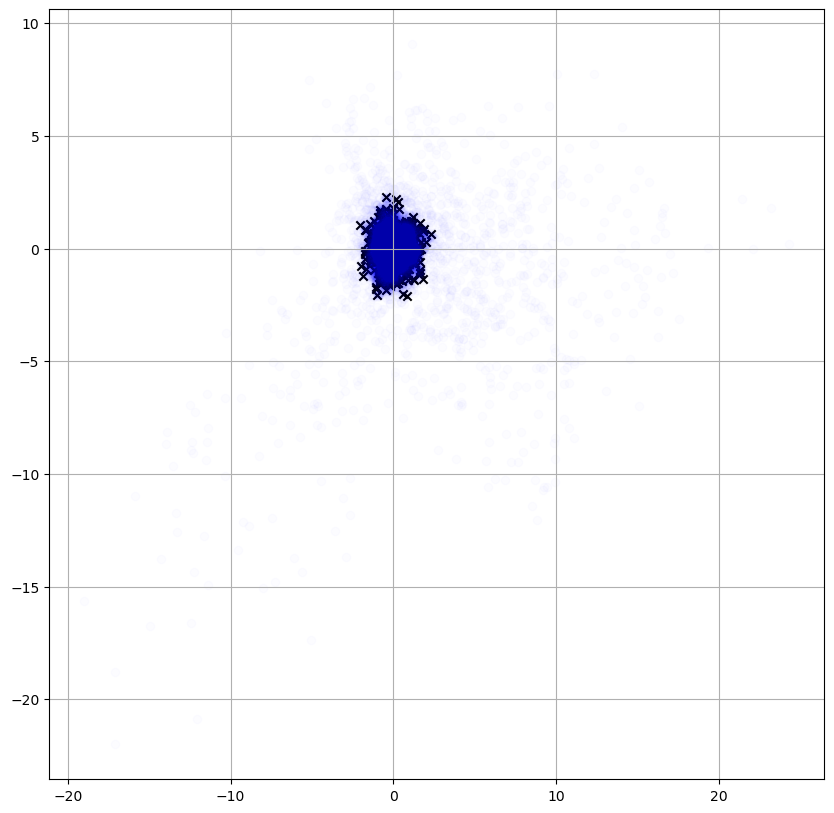

18001
lse_loss -55.37971115112305
commit_loss 1.515211820602417
recon_loss 0.01152884028851986
18002
lse_loss -55.26353073120117
commit_loss 1.512394666671753
recon_loss 0.011194261722266674
18003
lse_loss -55.4643669128418
commit_loss 1.488939881324768
recon_loss 0.01185351051390171
18004
lse_loss -55.536006927490234
commit_loss 1.5187618732452393
recon_loss 0.012393468990921974
18005
lse_loss -55.35819625854492
commit_loss 1.5588445663452148
recon_loss 0.012547947466373444
18006
lse_loss -55.57072830200195
commit_loss 1.5292167663574219
recon_loss 0.010744753293693066
18007
lse_loss -55.37809371948242
commit_loss 1.5248169898986816
recon_loss 0.011028194800019264
18008
lse_loss -55.42002487182617
commit_loss 1.5231622457504272
recon_loss 0.011934304609894753
18009
lse_loss -55.408138275146484
commit_loss 1.5247364044189453
recon_loss 0.01166857685893774
18010
lse_loss -55.47690200805664
commit_loss 1.4932763576507568
recon_loss 0.01151150744408369
18011
lse_loss -55.47822952270508
co

18086
lse_loss -55.41128158569336
commit_loss 1.5026178359985352
recon_loss 0.012002293020486832
18087
lse_loss -55.58015060424805
commit_loss 1.534519910812378
recon_loss 0.01129060983657837
18088
lse_loss -55.19228744506836
commit_loss 1.502236247062683
recon_loss 0.012847213074564934
18089
lse_loss -55.48152542114258
commit_loss 1.5106418132781982
recon_loss 0.013104005716741085
18090
lse_loss -55.291316986083984
commit_loss 1.5381258726119995
recon_loss 0.011105488985776901
18091
lse_loss -55.6027946472168
commit_loss 1.5089831352233887
recon_loss 0.011937199160456657
18092
lse_loss -55.31637191772461
commit_loss 1.521117091178894
recon_loss 0.012325480580329895
18093
lse_loss -55.51845169067383
commit_loss 1.5172550678253174
recon_loss 0.011649668216705322
18094
lse_loss -55.61106491088867
commit_loss 1.4991252422332764
recon_loss 0.011128949001431465
18095
lse_loss -55.33296585083008
commit_loss 1.5159001350402832
recon_loss 0.012557102367281914
18096
lse_loss -55.410884857177734

18173
lse_loss -55.45475387573242
commit_loss 1.502424716949463
recon_loss 0.013152053579688072
18174
lse_loss -55.32527542114258
commit_loss 1.5072615146636963
recon_loss 0.011208027601242065
18175
lse_loss -55.35133743286133
commit_loss 1.5114730596542358
recon_loss 0.012164011597633362
18176
lse_loss -55.454776763916016
commit_loss 1.5434303283691406
recon_loss 0.01226776372641325
18177
lse_loss -55.47322463989258
commit_loss 1.5191291570663452
recon_loss 0.012856866233050823
18178
lse_loss -55.264095306396484
commit_loss 1.5261106491088867
recon_loss 0.01229665707796812
18179
lse_loss -55.41193771362305
commit_loss 1.5156607627868652
recon_loss 0.011490914039313793
18180
lse_loss -55.34090042114258
commit_loss 1.5050511360168457
recon_loss 0.011212105862796307
18181
lse_loss -55.269649505615234
commit_loss 1.5633456707000732
recon_loss 0.013299698941409588
18182
lse_loss -55.4524040222168
commit_loss 1.5243635177612305
recon_loss 0.010667679831385612
18183
lse_loss -55.325046539306

18258
lse_loss -55.41567611694336
commit_loss 1.5296711921691895
recon_loss 0.013328692875802517
18259
lse_loss -55.1568717956543
commit_loss 1.4926562309265137
recon_loss 0.011560811661183834
18260
lse_loss -55.599308013916016
commit_loss 1.5023363828659058
recon_loss 0.011083714663982391
18261
lse_loss -55.645450592041016
commit_loss 1.5045651197433472
recon_loss 0.01145659014582634
18262
lse_loss -55.410457611083984
commit_loss 1.5270414352416992
recon_loss 0.012357017025351524
18263
lse_loss -55.58341598510742
commit_loss 1.4899797439575195
recon_loss 0.01261107251048088
18264
lse_loss -55.42824935913086
commit_loss 1.49298095703125
recon_loss 0.01277419738471508
18265
lse_loss -55.386959075927734
commit_loss 1.5478606224060059
recon_loss 0.013290507718920708
18266
lse_loss -55.42886734008789
commit_loss 1.5237325429916382
recon_loss 0.013051098212599754
18267
lse_loss -55.33335494995117
commit_loss 1.500025987625122
recon_loss 0.011703990399837494
18268
lse_loss -55.44392776489258

18343
lse_loss -55.45132827758789
commit_loss 1.5072741508483887
recon_loss 0.012424769811332226
18344
lse_loss -55.39718246459961
commit_loss 1.501420259475708
recon_loss 0.011865206062793732
18345
lse_loss -55.39150619506836
commit_loss 1.511391043663025
recon_loss 0.011646643280982971
18346
lse_loss -55.42878341674805
commit_loss 1.515697956085205
recon_loss 0.01358514279127121
18347
lse_loss -55.475704193115234
commit_loss 1.4949584007263184
recon_loss 0.010818331502377987
18348
lse_loss -55.47306442260742
commit_loss 1.5157063007354736
recon_loss 0.012062698602676392
18349
lse_loss -55.33796310424805
commit_loss 1.5087108612060547
recon_loss 0.013149171136319637
18350
lse_loss -55.180850982666016
commit_loss 1.449682593345642
recon_loss 0.011798841878771782
18351
lse_loss -55.26130294799805
commit_loss 1.4776694774627686
recon_loss 0.011876809410750866
18352
lse_loss -55.43368911743164
commit_loss 1.5456364154815674
recon_loss 0.01202060841023922
18353
lse_loss -55.51034927368164


lse_loss -55.2066764831543
commit_loss 1.515226125717163
recon_loss 0.011622927151620388
18429
lse_loss -55.1727409362793
commit_loss 1.489214539527893
recon_loss 0.01171763427555561
18430
lse_loss -55.22185134887695
commit_loss 1.505826711654663
recon_loss 0.011945486068725586
18431
lse_loss -55.44058609008789
commit_loss 1.4962157011032104
recon_loss 0.012319115921854973
18432
lse_loss -55.42436599731445
commit_loss 1.4904441833496094
recon_loss 0.011437846347689629
18433
lse_loss -55.4598274230957
commit_loss 1.5013022422790527
recon_loss 0.01170944795012474
18434
lse_loss -55.40666580200195
commit_loss 1.4940478801727295
recon_loss 0.013261600397527218
18435
lse_loss -55.40975570678711
commit_loss 1.5003267526626587
recon_loss 0.01207928266376257
18436
lse_loss -55.43765640258789
commit_loss 1.4972211122512817
recon_loss 0.014560755342245102
18437
lse_loss -55.36653518676758
commit_loss 1.5238844156265259
recon_loss 0.01281808316707611
18438
lse_loss -55.45534133911133
commit_loss 

lse_loss -55.443965911865234
commit_loss 1.5002708435058594
recon_loss 0.01151660829782486
18514
lse_loss -55.2677116394043
commit_loss 1.5280591249465942
recon_loss 0.013829763047397137
18515
lse_loss -55.5097541809082
commit_loss 1.506424903869629
recon_loss 0.013694616965949535
18516
lse_loss -55.41132736206055
commit_loss 1.5097486972808838
recon_loss 0.01171943824738264
18517
lse_loss -55.5284538269043
commit_loss 1.5116863250732422
recon_loss 0.011813848279416561
18518
lse_loss -55.4067497253418
commit_loss 1.527639389038086
recon_loss 0.013150637969374657
18519
lse_loss -55.438411712646484
commit_loss 1.5305936336517334
recon_loss 0.011242500506341457
18520
lse_loss -55.437747955322266
commit_loss 1.4947867393493652
recon_loss 0.011767871677875519
18521
lse_loss -55.336673736572266
commit_loss 1.4817217588424683
recon_loss 0.012046121060848236
18522
lse_loss -55.57786178588867
commit_loss 1.5059696435928345
recon_loss 0.011259528808295727
18523
lse_loss -55.55570602416992
commit

lse_loss -55.43687057495117
commit_loss 1.5125707387924194
recon_loss 0.012127417139708996
18599
lse_loss -55.50606155395508
commit_loss 1.513238549232483
recon_loss 0.011423751711845398
18600
lse_loss -55.43410873413086
commit_loss 1.5178673267364502
recon_loss 0.011446760967373848
18601
lse_loss -55.56619644165039
commit_loss 1.4901657104492188
recon_loss 0.011246344074606895
18602
lse_loss -55.35700607299805
commit_loss 1.4938219785690308
recon_loss 0.012157241813838482
18603
lse_loss -55.578487396240234
commit_loss 1.5068217515945435
recon_loss 0.011029931716620922
18604
lse_loss -55.32937240600586
commit_loss 1.5262335538864136
recon_loss 0.011876421049237251
18605
lse_loss -55.44655990600586
commit_loss 1.483597755432129
recon_loss 0.012311145663261414
18606
lse_loss -55.52846145629883
commit_loss 1.4972419738769531
recon_loss 0.011724492534995079
18607
lse_loss -55.53408432006836
commit_loss 1.5141164064407349
recon_loss 0.011311225593090057
18608
lse_loss -55.43490982055664
com

lse_loss -55.36943435668945
commit_loss 1.5264641046524048
recon_loss 0.012113562785089016
18684
lse_loss -55.499576568603516
commit_loss 1.519217848777771
recon_loss 0.011318782344460487
18685
lse_loss -55.52876663208008
commit_loss 1.5251429080963135
recon_loss 0.012632345780730247
18686
lse_loss -55.61277389526367
commit_loss 1.530097484588623
recon_loss 0.010952162556350231
18687
lse_loss -55.550045013427734
commit_loss 1.5297341346740723
recon_loss 0.011734448373317719
18688
lse_loss -55.50886917114258
commit_loss 1.4945802688598633
recon_loss 0.012163309380412102
18689
lse_loss -55.43373489379883
commit_loss 1.494868516921997
recon_loss 0.011983929201960564
18690
lse_loss -55.6170539855957
commit_loss 1.510206699371338
recon_loss 0.01190262846648693
18691
lse_loss -55.41744613647461
commit_loss 1.4768292903900146
recon_loss 0.011058598756790161
18692
lse_loss -55.46592330932617
commit_loss 1.525354027748108
recon_loss 0.012064854614436626
18693
lse_loss -55.392818450927734
commit

18769
lse_loss -55.48378372192383
commit_loss 1.5303878784179688
recon_loss 0.011470764875411987
18770
lse_loss -55.50602340698242
commit_loss 1.4941531419754028
recon_loss 0.012931816279888153
18771
lse_loss -55.7130012512207
commit_loss 1.4908535480499268
recon_loss 0.011867008171975613
18772
lse_loss -55.58292007446289
commit_loss 1.5077153444290161
recon_loss 0.01189473643898964
18773
lse_loss -55.46280288696289
commit_loss 1.5297603607177734
recon_loss 0.012132959440350533
18774
lse_loss -55.488460540771484
commit_loss 1.525857925415039
recon_loss 0.013212132267653942
18775
lse_loss -55.5450553894043
commit_loss 1.5118790864944458
recon_loss 0.0116262910887599
18776
lse_loss -55.55392074584961
commit_loss 1.5005862712860107
recon_loss 0.01279466599225998
18777
lse_loss -55.43758773803711
commit_loss 1.5415973663330078
recon_loss 0.011910736560821533
18778
lse_loss -55.53513717651367
commit_loss 1.5008795261383057
recon_loss 0.012529234401881695
18779
lse_loss -55.61933517456055
co

lse_loss -55.59938430786133
commit_loss 1.5103962421417236
recon_loss 0.011377020739018917
18855
lse_loss -55.23794937133789
commit_loss 1.4830234050750732
recon_loss 0.012920336797833443
18856
lse_loss -55.59653854370117
commit_loss 1.5038354396820068
recon_loss 0.011533752083778381
18857
lse_loss -55.297359466552734
commit_loss 1.5306792259216309
recon_loss 0.01200903207063675
18858
lse_loss -55.40424728393555
commit_loss 1.5101890563964844
recon_loss 0.012491250410676003
18859
lse_loss -55.494319915771484
commit_loss 1.5320426225662231
recon_loss 0.01600905880331993
18860
lse_loss -55.63664627075195
commit_loss 1.4954547882080078
recon_loss 0.011377722024917603
18861
lse_loss -55.36507034301758
commit_loss 1.4989447593688965
recon_loss 0.01152027677744627
18862
lse_loss -55.49637222290039
commit_loss 1.4860992431640625
recon_loss 0.011043015867471695
18863
lse_loss -55.51853561401367
commit_loss 1.508259654045105
recon_loss 0.012348581105470657
18864
lse_loss -55.60853958129883
comm

lse_loss -55.41183853149414
commit_loss 1.5313448905944824
recon_loss 0.012564185075461864
18941
lse_loss -55.599491119384766
commit_loss 1.512747049331665
recon_loss 0.01157444529235363
18942
lse_loss -55.4240608215332
commit_loss 1.470876932144165
recon_loss 0.01313256099820137
18943
lse_loss -55.562618255615234
commit_loss 1.4629361629486084
recon_loss 0.011933739297091961
18944
lse_loss -55.43364334106445
commit_loss 1.4280062913894653
recon_loss 0.010774574242532253
18945
lse_loss -55.63125228881836
commit_loss 1.5019128322601318
recon_loss 0.011901389807462692
18946
lse_loss -55.623470306396484
commit_loss 1.5092055797576904
recon_loss 0.010904925875365734
18947
lse_loss -55.49204635620117
commit_loss 1.5010080337524414
recon_loss 0.012004896998405457
18948
lse_loss -55.48117446899414
commit_loss 1.4958668947219849
recon_loss 0.011814571917057037
18949
lse_loss -55.5564079284668
commit_loss 1.4517011642456055
recon_loss 0.011272851377725601
18950


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)
            
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [14]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done
